In [ ]:
# necessary library imports
%matplotlib inline
import torchvision
import matplotlib.pyplot as plt
import time
import torch
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# code to set execution device to cuda, if it is available, otherwise set to 'CPU'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.') # displays the device utilized

Using cuda.


'CUDA' utilizes 'GPU' for computational processing, it is a parallel computing framework developed by NVIDIA

## DataSet
* The CIFAR10 comprises 60000 small (3 × 32 × 32) color images, each belonging to one of the airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck; 10 classes. The dataset is divided into  50000 images as training dataset and 10000 images as testing dataset.
* The dataset is preprocessed and loaded using $torchvision$ libraries.The preprocessing on the training set involves random horizontal flips and random pixel padding and cropping. Both training and testing datasets are transformed into tensors before loading. The Dataloader library manages batching, random shuffling and loading of training datasets and loading of testing datasets in memory.


In [ ]:
# UDF to load the CIFAR-10 dataset, apply additional augments with resize if required and then load it in memory
def load_data_CIFAR10(batch_size, resize=None):

    train_trans = [
        torchvision.transforms.RandomHorizontalFlip(), # filps training images horizontally (along its vertical axis) with default probability of 50%
        torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'), # apply 4 pixels padding per edge and randomly crops images to 32x32 size
        torchvision.transforms.ToTensor() # converts images to tensors
    ]
    test_trans = [torchvision.transforms.ToTensor()] # converts images to tensors

    if resize: # alters train, test image size to mentioned dimensions
        train_trans.insert(0, torchvision.transforms.Resize(resize))
        test_trans.insert(0, torchvision.transforms.Resize(resize))
    train_trans = torchvision.transforms.Compose(train_trans) # stacks augmentation techniques mentioned above in 'train_trans' list sequentially into a single operation
    test_trans = torchvision.transforms.Compose(test_trans) # combines transformation mentioned in 'test_trans' in single operation
    cifar_train = torchvision.datasets.CIFAR10(root="../data", train=True, transform=train_trans, download=True) # downloads the training dataset and specifies transformations mentioned in 'train_trans'
    cifar_test = torchvision.datasets.CIFAR10(root="../data", train=False, transform=test_trans, download=True) # downloads the testing dataset and specifies transformations mentioned in 'test_trans'
    return (torch.utils.data.DataLoader(cifar_train, batch_size, shuffle=True, num_workers=2, pin_memory=True), # loads the shuffled cifar_train dataset in pinned memory
            torch.utils.data.DataLoader(cifar_test, batch_size, shuffle=False, num_workers=2, pin_memory=True)) # loads the cifar_test data in pinned memory


Using Data from pinned memory, speed up training in GPU

In [ ]:
batch_size = 64 # declare value of the batch size
train_iter, test_iter = load_data_CIFAR10(batch_size) # load data in defined batch size using UDF load_data_CIFAR10 in 'train_iter' and 'test_iter' objects

100%|██████████| 170498071/170498071 [00:13<00:00, 12905639.29it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [ ]:
X, y = next(iter(train_iter)) # retrives first batch of images (X) and its corresponding labels (y)
print(X.size()) # 64 images per batch, each of dimension 3x32x32 (channel,height,width), '3' for RGB color channels
print(y.size()) # 64 targets, each from the 10 classes, labelled 0 to 9

torch.Size([64, 3, 32, 32])
torch.Size([64])



Image 0 (truck):



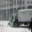


Image 1 (frog):



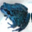


Image 2 (cat):



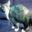

In [ ]:
from google.colab.patches import cv2_imshow

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] # given class labels of the CIFAR-10 dataset

for i in range(3):
    print(f'\nImage {i} ({class_labels[int(y[i])]}):\n') # displays 'i'th index and the associated label
    cv2_imshow(X[i].numpy().transpose(1, 2, 0) * 255) # displays batch converted 'i'th image

## Basic Block Architecture
* A basic block receives an image $x$ and outputs an image $x\_intermediate$.There are $3$ independent convolutional layers in the block, $c_1, c_2, c_3$. Each convolutional layer $C_i$ in the block receives the $same$ input image $x$ and outputs an image $C_i(x)$. Each output of these layers are combined into the single output tensor $x\_intermediate$, given by
$x\_intermediate = a_1C_1(x) + a_2C_2(x) + a_3C_3(x)$
where $a_1, a_2 ,a_3$ are the components of the vector\
  $\mathbf{a} = \begin{bmatrix} a_1 \\ a_2 \\ a_3 \end{bmatrix}$
.
* The vector $a$ is computed by taking the average value of each channel of $x$ (3 for first block) and stored into a $channel-dimensional\ vector$ 'm'.
The obtained vector $m$ is the input to a fully connected layer that outputs the required vector $a$. The fully connected layer $a$ have as many units as there are convolutional layers in the block.



In [ ]:
# Code Implements class BasicBlock
class BasicBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size, padding='same') # creates 2D convolution layer with specified parameters
        self.bn1 = torch.nn.BatchNorm2d(out_channels) # batch normalisation layer to stabilize lr
        self.max1 = torch.nn.MaxPool2d(3, stride=1) # applies Max Pooling layer of 3x3 window size on input images and stride 1
        self.relu1 = torch.nn.ReLU() # applies ReLU activation function

        self.conv2 = torch.nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.max2 = torch.nn.MaxPool2d(3, stride=1)
        self.relu2 = torch.nn.ReLU()

        self.conv3 = torch.nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
        self.bn3 = torch.nn.BatchNorm2d(out_channels)
        self.max3 = torch.nn.MaxPool2d(3, stride=1)
        self.relu3 = torch.nn.ReLU()

        self.linear = torch.nn.Linear(in_channels, 3) # initializes fully connected layer, mapping input channel to 3 outputs
        self.Sigmoid = torch.nn.Sigmoid() # applies sigmoid activation function


    def forward(self, x): # method defines forward image processing through above initialized architecture, same input 'x' applied on the three convolutional layers simultaneously

        c1 = self.conv1(x)
        c1 = self.bn1(c1)
        c1 = self.max1(c1)
        c1 = self.relu1(c1)

        c2 = self.conv2(x)
        c2 = self.bn1(c2)
        c2 = self.max2(c2)
        c2 = self.relu2(c2)

        c3 = self.conv3(x)
        c3 = self.bn1(c3)
        c3 = self.max3(c3)
        c3 = self.relu3(c3)

        m = torch.mean(x, dim=(2, 3)) # computes mean of x over height and width dimensions, tensor 'm' represents avg values of each channel for each image per batch
        # dimensions of vector 'm' is ['batch_size', 'in_channels'] i.e [64, 3] (1st block); [64, 96] (2nd block); [64, 256] (3rd Block)
        a = self.linear(m) # generates a vetor of dimension [64,3], by applying a fully connected layer on input vector 'm'
        a = self.Sigmoid(a) # applies sigmoid activation function on the fully connected layer a's dimension remains same

        x_intermediate = a[:, 0, None, None, None]* c1 + a[:, 1, None, None, None]* c2 + a[:, 2, None, None, None]* c3 # represents distinct weighted sum of convolutional layers, multiplied weights are the distinct compontents of vector 'a'

        return x_intermediate

## Output Block Architecture
* Output block receives an image $x\_intermediate$ (output of the last intermediate block) and outputs a $logits$ vector $o$
* Not using softmax activation function as CrossEntropyLoss function works on logits vector $o$ not on predicted labels 'y_hat'

In [ ]:
# Code Implements class OutputBlock
class OutputBlock(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        self.linear = torch.nn.Linear(in_channels, num_classes) # initializes fully connected layer, mapping input channel = 384 to 10 pre-defined classes

    def forward(self, x):
        m = torch.mean(x, dim = (2,3)) # computes mean of x over height and width dimensions, tensor 'm' represents avg values of each channel for image per batch, m is [64, 384] vector
        o = self.linear(m) # generates logits vetor of dimension [64,10], by applying a fully connected layer on input vector 'm'
        return o

## Intermediate Block Architecture
* The architecture is composed of a sequence of 3 intermediate blocks - block1 (in channels = 3, out channel =96), block2 (in channels = 96, out channel = 256),block3 (in channels = 256, out channel = 384) that are followed by an $OutputBlock$ o.
* The input to first block is the input image batches $x$ and the output of the block is the input to the next and so on. The last block's output is input to the $OutputBlock$ o. Thus, the $OutputBlock$ will have input channels = 384 and output channel = 10 $(number\ of\ classes)$ \\
[Block architecture.](https://drive.google.com/file/d/16zvkV-LLuTE2tZ1h5TlDjQ5pBnhrUMR3/view?usp=share_link)


In [ ]:
# Code Implements class IntermediateBlocks
class IntermediateBlocks(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(IntermediateBlocks, self).__init__()
        self.block1 = BasicBlock(in_channels=3, out_channels=96, kernel_size=3, padding=1) # initializes first block instance of the architecture with mentioned paramters
        self.block2 = BasicBlock(in_channels=96, out_channels=256, kernel_size=3, padding=1) # adds depth to model by initializing second block instance of the architecture with mentioned paramters
        self.block3 = BasicBlock(in_channels=256, out_channels= 384, kernel_size=3, padding=1) # initializes instance for the third block with mentioned parameters
        self.output = OutputBlock(in_channels=384, num_classes=num_classes) # initializes instance of output block with mentioned parameters

    def forward(self, x): # method defines forward image processing through above initialized architecture
        x1 = self.block1(x) # applies input image batches of size 64x3x32x32 each to first block
        x2 = self.block2(x1) # applies output batches of first block of size 64x96x30x30 each as input to second block
        x3 = self.block3(x2) # applies output batches of second block of size 64x256x28x28 each as input to third block
        o = self.output(x3) # applies output batches of third block of size 64x384x26x26 each as input to fully connected layer to get output logits 'o[64,10]' for each batch
        return o

## Parameter Initialization
* Below UDF initializes parameters of fully connected and convolution layers using 'He' initializer before computing the gradient of the loss w.r.t the parameters for the first time

In [ ]:
# UDF init_weights applies Kaiming initialization if the 'torch.nn.Module' is 'torch.nn.Conv2d' or  'torch.nn.Linear'
def init_weights(m):
  if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
    torch.nn.init.kaiming_uniform_(m.weight)

In [ ]:
model = IntermediateBlocks(num_classes=10).to(device) # creates an instance 'model' of the IntermediateBlocks with number of classifiers(10) and moves the model to 'device'
model.apply(init_weights) # applies'init_weights' to 'torch.nn.Module' inside 'model'

IntermediateBlocks(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (relu1): ReLU()
    (conv2): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (relu2): ReLU()
    (conv3): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (relu3): ReLU()
    (linear): Linear(in_features=3, out_features=3, bias=True)
    (Sigmoid): Sigmoid()
  )
  (block2): BasicBlock(
    (conv1): Conv2

## Loss Function
* To calculate the cross entropy loss function, created an instance 'loss' of the class 'CrossEntropyLoss'
* Since the function implements the desired cross entropy loss, it requires a logits vector $o$ and not predicted labels 'y_hat', hence not using softmax activation function in the Output Block

In [ ]:
loss = torch.nn.CrossEntropyLoss() # initializes cross entropy loss function

## Model Performance Improvement Techniques - Optimizer and Schedular
* Deployed AdamW with a learning rate of 0.002 and weight decay 0f 0.001 as optimization algorithm.
* As a subclass of 'torch.nn.Module' is declared in the model, the model parameters can be accessed through the method 'parameters'.
* Deployed StepLR schedular on the optimizer , with step size of 20 and the reduction rate 'gamma' is 0.1 or 10%

In [ ]:
lr = 2e-3 # initial learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay = 1e-3) # initializes AdamW optimizer with weight decay
schedular = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 20, gamma=0.1) # initialises lr scheduler StepLR, to reduce the lr by 10% in steps of 20 epochs

## Evaluation
* Below UDF calculates the logits vector for each row of each batch to determine predicted class of each image.
* The total correct predicted images can be calculated per batch

In [ ]:
# UDF to calculate total number of correct predictions
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # searches for a column with maximum value for each row of the 'logits' vector obtained from the model
    return (y_hat == y).float().sum() # computes total number of times prediction is correct i.e 'y_hat' and 'y' are same

* From the correct predicted image calculated above we can calculate the accuracy of the model by dividing their sum by the total number of actual labels in the dataset.

In [ ]:
# UDF to compute the average of correct prediction (accuracy) of the model
def evaluate_metric(model, data_iter, metric):
    c = 0.
    n = 0.
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # move the tensors and labels to 'device' (cuda)
        logits = model(X) # applies model on input tensors batch to get corresponding logits
        c += metric(logits, y) # sums the correct prediction of classes
        n += len(y) # calculates the total labels

    return float(c / n) # calculates the average to get the accuracy

In [ ]:
# model accuracy without Gradient Descent
print(f'Training accuracy: {evaluate_metric(model, train_iter, correct)}. Testing accuracy: {evaluate_metric(model, test_iter, correct)}.')

Training accuracy: 0.11289999634027481. Testing accuracy: 0.11189999431371689.


## Training

* Below code implements the training loop for the model.

* The training, testing dataset accuracy and training losses are displayed after for each epoch and training, testing accuracy and loss per training batch is stored as a list for plotting.

In [ ]:
losses_per_train_batch = [] # stores the losses each training batch in an ordered list
train_accuracy = [] # stores the train data accuracy for each batch in an ordered list
test_accuracy = [] # stores the test data accuracy for each batch in an ordered list
num_epochs = 45
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')

    for X, y in train_iter:
        X, y = X.to(device), y.to(device) # move the tensors and labels to 'device' (cuda)
        logits = model(X) # applies model on input tensors batch 'X' to get corresponding logits

        l = loss(logits, y) # computes the entropy loss for the calculated 'logits' vector and the pre-defined class vector 'y'
        optimizer.zero_grad() # resets the previous stored gradients in the model parameters
        l.backward() # computes the gradient of the loss 'l' with respect to the model parameters

        optimizer.step() # updates the model parameters based on the gradients obtained from the previous step

        losses_per_train_batch.append(float(l)) # store the losses obtained in every batch in losses_per_train_batch by appending the list

    schedular.step() # decays the learning rate after specific epoch (declared during its initialisation)

    with torch.no_grad(): # computes performance metrics without tracking gradients
        train_accuracy.append(evaluate_metric(model, train_iter, correct))
        test_accuracy.append(evaluate_metric(model, test_iter, correct))

        print(f'Training accuracy: {train_accuracy[-1]}. Testing accuracy: {test_accuracy[-1]}. Training losses:{losses_per_train_batch[-1]}') # computes and displays training/testing dataset accuracy and training losses



Epoch 1/45.
Training accuracy: 0.5740199685096741. Testing accuracy: 0.5756999850273132. Training losses:1.5863170623779297

Epoch 2/45.
Training accuracy: 0.6204800009727478. Testing accuracy: 0.6254000067710876. Training losses:0.8102722764015198

Epoch 3/45.
Training accuracy: 0.6566799879074097. Testing accuracy: 0.656499981880188. Training losses:0.9150891304016113

Epoch 4/45.
Training accuracy: 0.7001599669456482. Testing accuracy: 0.699999988079071. Training losses:1.0164601802825928

Epoch 5/45.
Training accuracy: 0.707859992980957. Testing accuracy: 0.7073999643325806. Training losses:1.178362250328064

Epoch 6/45.
Training accuracy: 0.738860011100769. Testing accuracy: 0.7312999963760376. Training losses:1.0295145511627197

Epoch 7/45.
Training accuracy: 0.7604199647903442. Testing accuracy: 0.7479999661445618. Training losses:0.9663805961608887

Epoch 8/45.
Training accuracy: 0.7759400010108948. Testing accuracy: 0.7639999985694885. Training losses:0.2752150297164917

Epoc

## Plots
* From the training loss per epoch data obtained in previous step, the plot of the loss per training batch is obtained.
* The training and testing accuracy variation per epoch is also plotted for observation.

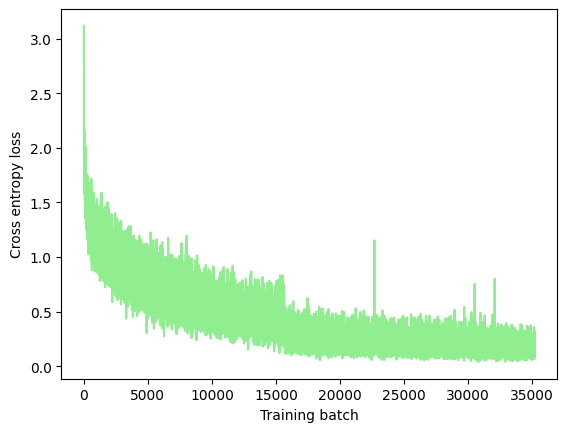

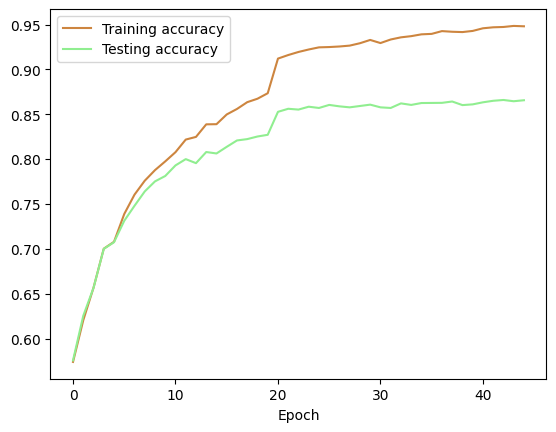

In [ ]:
# Plots of Required graphs
plt.plot(losses_per_train_batch, color='lightgreen') # plots the loss for each training batch using the list 'losses_per_train_batch'
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(train_accuracy, label='Training accuracy', color='peru') # plots the trainning accuracy after each epoch
plt.plot(test_accuracy, label='Testing accuracy', color='lightgreen') # plots the test accuracy after each epoch
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()